<a href="https://colab.research.google.com/github/maxjonasbehrens/master_thesis_code/blob/master/ee_import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## First Test to import tfrecords images from EE

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!pip install pyrsgis

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import pyrsgis
import cv2
from skimage.transform import resize
from PIL import Image
%matplotlib inline 
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
import scipy.io

Warning! matplotlib_scalebar library not found.


## Exploration

In [6]:
# Reload missed images
mypath = "/gdrive/My Drive/nuts_geotiff/"
onlyfiles = [f.split('.')[0] for f in listdir(mypath) if isfile(join(mypath, f))]
print(onlyfiles)

['AL02_2016', 'AL02_2017', 'CZ05_2016', 'AT32_2016', 'AT32_2017', 'CZ05_2017', 'AT11_2017', 'AT11_2016', 'BG41_2016', 'BG41_2017', 'DE14_2016', 'DE14_2017', 'AT34_2016', 'BE10_2016', 'BE10_2017', 'AT34_2017', 'CZ08_2016', 'AT22_2016', 'CZ08_2017', 'AT22_2017', 'BG32_2016', 'BE24_2016', 'BE24_2017', 'BG32_2017', 'BE25_2017', 'CZ06_2016', 'BE25_2016', 'CZ06_2017', 'AT12_2016', 'AT13_2016', 'AT13_2017', 'AT12_2017', 'AT21_2016', 'AT21_2017', 'CZ03_2017', 'CZ01_2016', 'CZ01_2017', 'CZ03_2016', 'BE23_2016', 'BE33_2016', 'BE33_2017', 'BE23_2017', 'CZ07_2016', 'BE34_2016', 'BE34_2017', 'DE22_2016', 'DE22_2017', 'BE35_2016', 'BE35_2017', 'CZ07_2017', 'CZ04_2016', 'CZ04_2017', 'BG31_2016', 'BG31_2017', 'AL01_2016', 'AL01_2017', 'AT31_2016', 'AT31_2017', 'DE73_2016', 'DE73_2017', 'DE93_2016', 'DE93_2017', 'DE91_2016', 'DE91_2017', 'DE92_2016', 'DE92_2017', 'DE26_2016', 'DE26_2017', 'EL53_2016', 'EL53_2017', 'FR10_2016', 'FR10_2017', 'DE30_2016', 'DE30_2017', 'ES23_2017', 'HU11_2016', 'HU11_2017'

In [0]:
al01_2016_path = "/gdrive/My Drive/nuts_night_all/DE22_2012.tif"

ds1, featuresAL01 = pyrsgis.raster.read(al01_2016_path)

In [5]:
print("AL01 shape: ",featuresAL01.shape)

AL01 shape:  (3588, 8325)


In [0]:
len_list = []
for i in range(featuresAL01.shape[0]):
  len_list.append(len(featuresAL01[i][~np.isnan(featuresAL01[i])]))

print(np.mean(len_list))

4845.33723522854


In [0]:
# Reshape image to be a rectangle
raw_list = []
h_temp = None
x_step = 12
y_step = 25
y_len = len_mean

for x in range(0,featuresAL01.shape[0],x_step):
  for y in range(0,featuresAL01.shape[1],y_step):
    if np.any(np.isnan(featuresAL01[x:x+x_step,y:y+y_step])) == False:
      if h_temp is None:
        h_temp = featuresAL01[x:x+x_step,y:y+y_step]
      elif h_temp.shape[1] >= len_mean:
        raw_list.append(h_temp)
        h_temp = None
      else:
        h_temp = np.hstack((h_temp,featuresAL01[x:x+x_step,y:y+y_step]))

In [0]:
# Test function
raw_list = prepocess_image(featuresAL01)

In [0]:
# Check function if the output is correct
len_list = []
for i in range(len(raw_list)):
  if raw_list[i] is None:
    pass
  else:
    len_list.append(raw_list[i].shape[1])

In [0]:
print(np.max(len_list))
print(np.min(len_list))
print(len(raw_list))

4875
4875
35


In [0]:
final_features = np.array(raw_list,dtype=np.uint8)
new_shape = final_features.shape[0]*final_features.shape[1]
final_features = final_features.reshape((new_shape,final_features.shape[2]))
print(final_features.shape)

(3220, 4875)


In [0]:
al01_resized = resize(featuresAL01, (256,256))

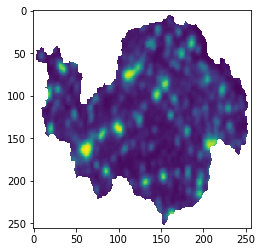

In [7]:
# Show the test image
plt.imshow(al01_resized, interpolation='nearest')
plt.show()

In [8]:
# Check the data frame
y_dat = pd.read_csv("/gdrive/My Drive/ThesisData/Data/nuts_gdp_cleaned.csv")
y_dat.head()

,region,year,value,code,country
0,BE,2008,33100.0,BE,Belgium
1,BE1,2008,61100.0,BE,Belgium
2,BE10,2008,61100.0,BE,Belgium
3,BE2,2008,33100.0,BE,Belgium
4,BE21,2008,39200.0,BE,Belgium


In [0]:
def prepocess_image(image):
  len_list = []
  for i in range(image.shape[0]):
    len_list.append(len(image[i][~np.isnan(image[i])]))

  for i in range(1,101):
    if image.shape[0] % i == 0:
      x_step = i
    if image.shape[1] % i == 0:
      y_step = i

  len_mean = np.mean(len_list)
  processed_image = []
  h_temp = None

  for x in range(0,image.shape[0],x_step):
    for y in range(0,image.shape[1],y_step):
      if np.any(np.isnan(image[x:x+x_step,y:y+y_step])) == False:
        if h_temp is None:
          h_temp = image[x:x+x_step,y:y+y_step]
        elif h_temp.shape[1] >= len_mean:
          processed_image.append(h_temp)
          h_temp = None
        else:
          h_temp = np.hstack((h_temp,image[x:x+x_step,y:y+y_step]))
  
  final_features = np.array(processed_image,dtype=np.uint8)
  new_shape = final_features.shape[0]*final_features.shape[1]
  final_features = final_features.reshape((new_shape,final_features.shape[2]))
  
  return final_features

In [0]:
def create_data(files,path,y_dat,resolution = 256):
  x = []
  y = []
  label = []
  i = 0
  for f in files:
    if i % 10 == 0:
      print("Image processed: ",str(i)," of ",str(len(files)))
    ds, temp = pyrsgis.raster.read(str(path+f))
    temp = prepocess_image(temp)
    temp_resized = resize(temp, (resolution, resolution))
    x.append(temp_resized)
    split1 = f.rsplit('_',1)[0]
    split2 = int(f.rsplit('_',1)[1].rsplit('.',1)[0])
    y.append(y_dat.loc[(y_dat['region']==split1) & (y_dat['year']==split2),'value'])
    label.append(f)
    i += 1
  return x, y, label

def create_y_label(files,path,y_dat):
  y = []
  label = []
  for f in files:
    split1 = f.rsplit('_',1)[0]
    split2 = int(f.rsplit('_',1)[1].rsplit('.',1)[0])
    y.append(y_dat.loc[(y_dat['region']==split1) & (y_dat['year']==split2),'value'])
    label.append(f)
  return y, label

In [0]:
# List of all files in directory
mypath = "/gdrive/My Drive/nuts_night_all/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [12]:
res = 512
x,y,label = create_data(onlyfiles,mypath,y_dat,resolution=res)

Image processed:  0  of  558
Image processed:  10  of  558
Image processed:  20  of  558
Image processed:  30  of  558
Image processed:  40  of  558
Image processed:  50  of  558
Image processed:  60  of  558
Image processed:  70  of  558
Image processed:  80  of  558
Image processed:  90  of  558
Image processed:  100  of  558
Image processed:  110  of  558
Image processed:  120  of  558
Image processed:  130  of  558
Image processed:  140  of  558
Image processed:  150  of  558
Image processed:  160  of  558
Image processed:  170  of  558
Image processed:  180  of  558
Image processed:  190  of  558
Image processed:  200  of  558
Image processed:  210  of  558
Image processed:  220  of  558
Image processed:  230  of  558
Image processed:  240  of  558
Image processed:  250  of  558
Image processed:  260  of  558
Image processed:  270  of  558
Image processed:  280  of  558
Image processed:  290  of  558
Image processed:  300  of  558
Image processed:  310  of  558
Image processed:  3

In [0]:
# Save ndarray to reproduce
scipy.io.savemat("/gdrive/My Drive/ThesisData/Data/data_all_input_512.mat", mdict={'x': x}, oned_as='row')

In [0]:
# Load input from scratch
x = scipy.io.loadmat("/gdrive/My Drive/ThesisData/Data/data_all_input_512.mat")['x']
y, label = create_y_label(onlyfiles,mypath,y_dat)

In [32]:
print('Shape of x: ',len(x))
print('Shape of y: ',len(y))
print('Shape of labels: ', len(label))

Shape of x:  558
Shape of y:  558
Shape of labels:  558


In [33]:
# Make x to a 3 channel image
x = np.repeat(x[..., np.newaxis], 3, -1)
print(x.shape)

(558, 512, 512, 3)


## Create Train and Test Sets

In [34]:
regions = []
for i in range(len(label)):
  regions.append(label[i].rsplit('_',1)[0])

regions = np.unique(regions)
print(len(regions))

93


In [35]:
msk = np.random.rand(len(regions)) < 0.7
train_split = regions[msk]
test_split = regions[~msk]
print(len(train_split))
print(len(test_split))

67
26


In [38]:
import math
label_train = []
label_test = []
x_train = []
y_train = []
x_test = []
y_test = []
for i in range(len(label)):
  if label[i].rsplit('_',1)[0] in train_split:
    if math.isnan(y[i]):
      pass
    else:
      label_train.append(label[i])
      x_train.append(x[i])
      y_train.append(int(y[i]))
  else:
    if math.isnan(y[i]):
      pass
    else:
      label_test.append(label[i])
      x_test.append(x[i])
      y_test.append(int(y[i]))
  
label_train = np.array(label_train)
label_test = np.array(label_test)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)  
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)

(286, 512, 512, 3)
(148, 512, 512, 3)
(148,)


In [37]:
x_train = np.array([x_train])
x_train = np.moveaxis(x_train,0,-1)
print(x_train.shape)
x_test = np.array([x_test])
x_test = np.moveaxis(x_test,0,-1)
print(x_test.shape)

(286, 512, 512, 3, 1)
(148, 512, 512, 3, 1)


In [19]:
# Deep Model
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, 3, padding='same', input_shape=(512,512,1), activation='relu'))
model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=1, activation = 'linear'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [39]:
# Transfer Learning
base_model = tf.keras.applications.MobileNet(input_shape=(512,512,3),include_top=False)
x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(units=1, activation = 'linear')(x)
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)

17227776/17225924 [==============================] - 1s 0us/step


In [0]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])

In [0]:
# Data Augmentation
training_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator()

In [0]:
# Data Preparation
batch_size = 5

# Define the data flow
training_generator = training_data_generator.flow(x_train,y_train,batch_size=batch_size)
test_generator = test_data_generator.flow(x_test,y_test,batch_size=1,shuffle=False)

In [43]:
# Calculate the number of steps
training_steps = training_generator.n/batch_size

# Run the model
model.fit_generator(training_generator,
                    steps_per_epoch=training_steps,
                    epochs = 100,
                    verbose = 1
                   )

Epoch 1/100
58/57 [==============================] - 25s 438ms/step - loss: 347219103.0766 - mean_squared_error: 344693568.0000 - mean_absolute_error: 12921.1885
Epoch 2/100
58/57 [==============================] - 18s 308ms/step - loss: 166973392.8075 - mean_squared_error: 168419072.0000 - mean_absolute_error: 9376.7510
Epoch 3/100
58/57 [==============================] - 18s 308ms/step - loss: 158110951.4784 - mean_squared_error: 158260992.0000 - mean_absolute_error: 9118.2188
Epoch 4/100
58/57 [==============================] - 18s 306ms/step - loss: 147959354.9010 - mean_squared_error: 146895344.0000 - mean_absolute_error: 8613.9072
Epoch 5/100
58/57 [==============================] - 18s 310ms/step - loss: 126158127.5803 - mean_squared_error: 124743136.0000 - mean_absolute_error: 7875.1206
Epoch 6/100
58/57 [==============================] - 18s 306ms/step - loss: 94128973.3866 - mean_squared_error: 94482928.0000 - mean_absolute_error: 7231.8521
Epoch 7/100
58/57 [================

In [44]:
# Calculate the test performance
test_score = model.evaluate_generator(test_generator)
print('Test loss: '+str(test_score[0]))
print('Test MSE: '+str(test_score[1]))
print('Test MAE: '+str(test_score[2]))

Test loss: 213706958.70185646
Test MSE: 213706930.0
Test MAE: 10974.577
